In [46]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import Module, Parameter
import numpy as np
import math
from IPython import display

In [47]:
# source time function
def ricker(freq, length, dt, peak_time):
    """Return a Ricker wavelet with the specified central frequency.
    Args:
        freq: A float specifying the central frequency
        length: An int specifying the number of time samples
        dt: A float specifying the time sample spacing
        peak_time: A float specifying the time (in secs) of the peak amplitude
    """
    t = np.arange(0,length)*dt - peak_time
    y = (1-2*math.pi**2 * freq**2 * t**2) * np.exp(-math.pi**2 * freq**2 * t**2)
    return y

In [48]:
class RNNCell_FD(Module):
    def __init__(self, dx, dt, isrc, ir, nx, vel):
        super(RNNCell_FD, self).__init__()
        self.dx = dx          # grid point distance in x-direction
#         self.ir = ir          # receiver position in x-direction
#         self.isrc = isrc      # source position in x-direction
        self.nx = nx          # number of grid points in x-direction
        self.dt = dt          # sample delta
        kernel = [1/(dx**2), -2/(dx**2), 1/(dx**2)] # laplacian operator in space
        kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        vel_init = vel**2 * self.dt  # the 1-D velocity model, vel: velocity(1-D tensor)
        vel_init = vel_init.unsqueeze(0).unsqueeze(0)  # expend to 3-D tensor
        self.vel = Parameter(data=vel_init, requires_grad=True)
        self.weight_conv = Parameter(data=kernel, requires_grad=False)
        
        
    def forward(self, input, h_current, h_old, isrc, ir):
        ''' Forward calculating
        Args:
            input: the i-th value of source time function
            h_current: current wavefield
            h_old: previous wavefield
        '''
        self.ir = ir
        self.isrc = isrc
        if vel.shape[-1] != self.nx:
            # check the lenght of velocity model for nx
            print(f'[ERROR]: velocity model length {vel.shape[-1]} != {nx}!')
            pause
            
        # calculate space gradient
        d2px = F.conv1d(h_current, self.weight_conv)
        
        if d2px.shape[-1] != self.nx and (self.nx - d2px.shape[-1]) % 2 == 0:
            padd = int((self.nx - d2px.shape[-1]) / 2)
            d2pxx = F.pad(d2px, (padd, padd))   # padding the space gradient in order to have same dimension
            pure_d2px = d2pxx * self.vel *self.dt
        else:
            print(f'[ERROR]: Conv lenght {nx} - {d2px.shape[-1]} ={self.nx - d2px.shape[-1]} !')
            pure_d2px = d2px * self.vel * self.dt
        
        vel_value = torch.tensor(0.0, requires_grad=True)   # auxiliary tensor
        local_vel = torch.sqrt(self.vel[0,0,-1] / self.dt) + vel_value # get the last point velocity of model
        
        # get the next wavefield
        h_next = pure_d2px - h_old + 2 * h_current
        # add source term:
        source_factor = torch.zeros(1,1,self.nx, requires_grad=True)   # auxiliary tensor
        source_factor_deta = source_factor.detach()
        source_factor_deta[0,0,self.isrc] = input * self.dt**2 * 1 / self.dx * self.vel[0,0,self.isrc]**2
        # h_next_plus_sr: the next wavefield
        h_next_plus_sr = h_next + source_factor
        
        
        #  boundary conditions
        # the fist point: open conditions
        value = h_next_plus_sr[0,0,-2] - 1/local_vel * (h_next_plus_sr[0,0,-2] - h_current[0,0,-2])*self.dx/self.dt
        ttmp = torch.zeros(1,1,self.nx, requires_grad=True)   # auxiliary tensor
        ttmp_deta = ttmp.detach()
        ttmp_deta[0,0,-1] = value
        tmp = torch.ones(1,1,self.nx, requires_grad=True)   # auxiliary tensor
        tmp_tmp = tmp.detach()
        tmp_tmp[0,0,-1] = 0
        h_next_plus_sr_bd = h_next_plus_sr * tmp + ttmp
        
        # the end point: fixed conditions
        tmp_zero = torch.ones(1,1,self.nx, requires_grad=True)
        tmp_zero_deta = tmp_zero.detach()
        tmp_zero_deta[0,0,0] = 0
        # h_next_plus_sr_bd_total: the next wavefield included source term and boundary conditions
        h_next_plus_sr_bd_total = h_next_plus_sr_bd * tmp_zero
        
        # get wavefield amplitude of the receiver position -> record
        delta_r = torch.zeros(nx,1,requires_grad=True)
        delta_r_d = delta_r.detach()
        delta_r_d[self.ir,0] = 1
        record = torch.mm(h_next_plus_sr_bd_total.squeeze(0), delta_r)

        # return current wavefield, next wavefield, amplitude of the receiver position
        return h_current, h_next_plus_sr_bd_total, record
        

In [49]:
dt = 0.001                     # delta
timeLen = 1                    # in second
nt = int(timeLen/dt)           # sample points
peak_freq = 10                  # in Hz
q0 = 1
peak_sorce_time = 1/peak_freq  #
source_amplitudes = q0 * ricker(peak_freq, nt, dt, peak_sorce_time)
src = source_amplitudes

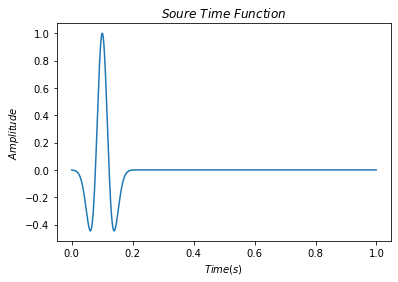

In [50]:
# plot source time function
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(np.arange(0,nt)*dt,source_amplitudes)
plt.xlabel('$Time(s)$')
plt.ylabel('$Amplitude$')
plt.title('$Soure\ Time\ Function$')
#plt.grid(ls='--')
plt.show()

[180 175 170 165 160 155 150 145 140 135 130 125 120 115 110 105 100  95
  90  85  80  75  70  65  60  55  50  45  40  35  30  25  20]
[198 187 176 166 155 144 134 123 112 102  91  80  70  59  48  38]
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4

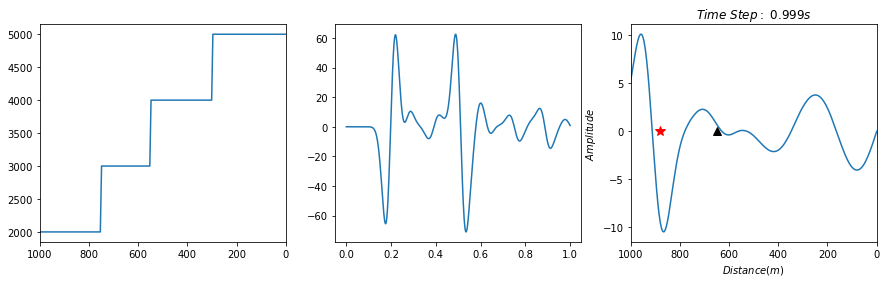

In [63]:
# 1D Wave Propagation (Finite Difference Solution)

nx   = 200         # number of grid points in x-direction
dx   = 5          # grid point distance in x-direction
isrc = 198          # source location in grid in x-direction
ir   = 180          # receiver location in grid in x-direction
mul_ir = np.linspace(180, 20, 33, dtype=int)
mul_isrc = np.linspace(198, 38, 16, dtype=int)
print(mul_ir)
print(mul_isrc)

seis = np.zeros((len(mul_isrc),len(mul_ir),nt))              # receiver amplitude

vel = torch.cat((torch.ones(60)*5000, torch.ones(50)*4000, torch.ones(40)*3000, torch.ones(50)*2000))
vel_test1 = torch.cat((torch.ones(40)*5000, torch.linspace(5000,4000,30), 
                       torch.ones(30)*4000, torch.linspace(4000,3000,20), 
                       torch.ones(20)*3000, torch.linspace(3000,2000,30), 
                       torch.ones(30)*2000))
#vel_test = torch.from_numpy(sm_vel_new_value)
#vel_test = sm_vel_new_value
net = RNNCell_FD(dx, dt, isrc, ir, nx, vel)
net = net.float()
check_it = -1
for i, isrc_items in enumerate(mul_isrc):
    for indexs, ir_items in enumerate(mul_ir):
        h_current = torch.zeros(1,1,nx)  # current wavefield
        h_old = torch.zeros(1,1,nx)      # previous wavefield
        print(i, indexs)
        for it in range(nt):  # the time, from 0-th to nt-th wavefield
            # forward:
            h_old, h_current, record = net(src[it], h_current, h_old, isrc_items, ir_items)
            seis[i][indexs][it] = record
            if it == range(nt)[check_it] and i == 2 and indexs == 10: # plot the check_it-th wavefield
                print(h_old.shape, h_current.shape)
                plt.figure(figsize=(15,4))
                ax3 = plt.subplot(131)
                ax3.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy())
                ax3.set_xlim([0, nx*dx])
                ax3.invert_xaxis()

                ax1 = plt.subplot(132)
                time = np.linspace(0 * dt, nt * dt, nt)
                ax1.plot(time, seis[i, indexs, :])

                ax2 = plt.subplot(133)
                ax2.plot(np.linspace(0 * dx, nx * dx, nx), h_current[0,0,:].detach().numpy())
                ax2.plot(isrc_items*dx, 0, 'r*', markersize=11) # source position
                ax2.plot(ir_items*dx, 0, 'k^', markersize=8) # receiver position
                ax2.set_xlim([0, nx*dx])
                ax2.set_xlabel('$Distance(m)$')
                ax2.set_ylabel('$Amplitude$')
                ax2.set_title(f'$Time\ Step:\ {it*dt}s$')
                ax2.invert_xaxis()
#                 plt.pause(0.01)
#                 display.clear_output(wait=True)


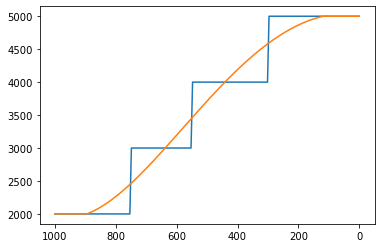

In [64]:
target = seis # inverstion target

# smoothing the true velocity model
N = 60
weights = np.hanning(N)
smooth_vel = np.convolve(weights/weights.sum(), vel.numpy(), 'same')
sm_vel_poly = np.polyfit(np.linspace(0 * dx, nx * dx, nx), vel.numpy(), 4)
sm_vel_value = np.polyval(sm_vel_poly, np.linspace(0 * dx, nx * dx, nx))

sm_vel_new_value = sm_vel_value
sm_vel_new_value[sm_vel_new_value>5000] = sm_vel_new_value[sm_vel_new_value>5000]*0+5000.
sm_vel_new_value[sm_vel_new_value<2000] = sm_vel_new_value[sm_vel_new_value<2000]*0+2000.

plt.figure()
ax_vel_true = plt.subplot(111)
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy())
# ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), smooth_vel)
# ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), sm_vel_value)
# the initial velocity model
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), sm_vel_new_value)
ax_vel_true.invert_xaxis()

In [65]:
# init velocity
sm_vel_new_value = torch.from_numpy(sm_vel_new_value)

netInv = RNNCell_FD(dx, dt, isrc, ir, nx, sm_vel_new_value)
netInv = netInv.float()


In [66]:
optimizer = torch.optim.RMSprop(netInv.parameters(), lr=25)
loss_func = nn.MSELoss()

In [ ]:
from torch.autograd import Variable

target = torch.from_numpy(target).float()
total_loss = []
# with torch.autograd.set_detect_anomaly(True):
epoch = 200 # epoch: iterations 
for step in range(epoch):
    seisInv = Variable(torch.zeros((len(mul_isrc), len(mul_ir),nt)))
    print(f'{step}/{epoch}:')
    for ii, isrc_items in enumerate(mul_isrc):
        for indexs, ir_items in enumerate(mul_ir): 
            # initialization
            h_current_Inv = Variable(torch.zeros(1,1,nx))
            h_old_Inv = Variable(torch.zeros(1,1,nx))
            for it in range(nt):
                # forward:
                h_old_Inv, h_current_Inv, seisInv[ii][indexs][it] = netInv(torch.tensor(src[it]), h_current_Inv, h_old_Inv, isrc_items, ir_items)
        #             h_old_Inv[it+1,...] = h_old_Inv[it+1,...].detach()
        #             h_current_Inv[it+1,...] = h_current_Inv[it+1,...].detach()
        #         if it == 0:
        #             total_seisInv = seisInv.unsqueeze(0)
        #             total_target = torch.cat((target[:(it+1)], torch.zeros(len(target)-len(target[:it+1])))).unsqueeze(0)
        #         else:
        #             total_seisInv = torch.cat((total_seisInv, seisInv.unsqueeze(0)),0)
        #             total_target = torch.cat((total_target, 
        #                                         torch.cat((target[:(it+1)], torch.zeros(len(target)-len(target[:it+1])))).unsqueeze(0)),0)

                #total_target = torch.cat((target[:(it+1)]), torch.zeros(len(target)-len(target[:it+1])))
    loss = loss_func(seisInv, target)
    total_loss.append(loss.data)
    optimizer.zero_grad()
    loss.backward() # inverstion
    #loss.backward(retain_graph=True)
    optimizer.step() # update velocity pamarmeter

    #plt.clf() # clear axis
    plt.figure(figsize=(13,5))
    plt.ion()
    plt.subplot(131)
    seisInvClone = seisInv.clone()
    plt.plot(np.linspace(0 * dt, nt * dt, nt), target.numpy()[0][0], 'k')
    plt.plot(np.linspace(0 * dt, nt * dt, nt), seisInvClone.detach().numpy()[0][0])

    plt.subplot(132)
    pama = [x for x in netInv.parameters()]
    plt.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy(), 'k')
    pamaClone = pama[0].clone()
    plt.plot(np.linspace(0 * dx, nx * dx, nx), np.sqrt(pamaClone.detach()[0,0,:].numpy()/dt))

    plt.subplot(133)
    plt.plot(total_loss)
    plt.title(f'{step}')

    plt.tight_layout()
    plt.draw()
    plt.pause(1)
    display.clear_output(wait=True)
    plt.ioff()
    plt.show()

1/200:


In [12]:
for name, p in netInv.named_parameters():
    print(name, p)

vel Parameter containing:
tensor([[[25000.0000, 24790.8203, 24782.8906, 24782.2480, 24783.0938,
          24784.6582, 24786.7441, 24789.2656, 24792.1992, 24795.5098,
          24799.1738, 24803.1660, 24807.4570, 24812.0215, 24816.8262,
          24821.8340, 24827.0059, 24832.2949, 24837.6582, 24843.0488,
          24848.4297, 24853.7871, 24859.0938, 24864.3887, 24850.7090,
          24798.6035, 24743.5000, 24685.7012, 24625.5723, 24563.5645,
          24500.1055, 24435.6309, 24370.4219, 24304.6699, 24238.3242,
          24171.2051, 24102.9043, 24032.9180, 23960.6328, 23885.4238,
          23806.6348, 23723.6348, 23635.8262, 23542.5957, 23443.3711,
          23337.5000, 23224.2754, 23102.8828, 22972.3457, 22831.4805,
          22678.8789, 22512.8750, 22331.5410, 22132.8848, 21915.0938,
          21677.2207, 21419.9941, 21146.8145, 20864.0371, 20580.1699,
          20303.8359, 20041.8047, 19798.1016, 19574.3340, 19370.5176,
          19185.9512, 19019.7109, 18870.9023, 18738.6543, 18621.

In [13]:
netInv.vel.grad # the velocity pamarmeter gradient

tensor([[[ 0.0000e+00,  6.0756e-08,  2.3803e-07,  5.1667e-07,  8.7252e-07,
           1.2737e-06,  1.6828e-06,  2.0583e-06,  2.3579e-06,  2.5405e-06,
           2.5685e-06,  2.4105e-06,  2.0421e-06,  1.4482e-06,  6.2410e-07,
          -4.2508e-07, -1.6856e-06, -3.1333e-06, -4.7375e-06, -6.4622e-06,
          -8.2676e-06, -1.0113e-05, -1.1959e-05, -1.3771e-05, -1.5543e-05,
          -1.7288e-05, -1.8955e-05, -2.0536e-05, -2.2040e-05, -2.3478e-05,
          -2.4874e-05, -2.6256e-05, -2.7656e-05, -2.9108e-05, -3.0647e-05,
          -3.2303e-05, -3.4096e-05, -3.6038e-05, -3.8128e-05, -4.0350e-05,
          -4.2669e-05, -4.5034e-05, -4.7378e-05, -4.9617e-05, -5.1657e-05,
          -5.3392e-05, -5.4710e-05, -5.5502e-05, -5.5660e-05, -5.5086e-05,
          -5.3701e-05, -5.1444e-05, -4.8276e-05, -4.4185e-05, -3.9186e-05,
          -3.3322e-05, -2.6664e-05, -1.9315e-05, -1.1422e-05, -3.1870e-06,
           5.1325e-06,  1.3226e-05,  2.0759e-05,  2.7396e-05,  3.2834e-05,
           3.6819e-05,  3